In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [5]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from crowd_model import MCNN
from dataloader import CrowdDataset
from torchvision import datasets, transforms
import torch
%matplotlib inline

In [4]:
!pip install Image

     |████████████████████████████████| 7.9 MB 2.7 MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19494 sha256=635b2c8c1cfe558b8d5ad429981bac045624b77f7c87343123a5a8c1825e9a01
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built Image


In [6]:
def mae(img_root,gt_dmap_root,model_checkpoint_path):
    
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    mae=0
    with torch.no_grad():
        for i,(img,groundtruth_dmap) in enumerate(dataloader):
            img=img.to(device)
            #img = transform(Image.open(img_paths[i]).convert('RGB')).to(device)
            
            #Groundtruth Desnity Map
            groundtruth_dmap=groundtruth_dmap.to(device)

            #Estimate Density Map
            estimate_dmap=mcnn(img)
            # Calculate MAE
            mae+=abs(estimate_dmap.data.sum()-groundtruth_dmap.data.sum()).item()
            del img,groundtruth_dmap,estimate_dmap

    print(mae/len(dataloader))

In [21]:
def estimate_density_map(img_root,gt_dmap_root,model_checkpoint_path,index):
  
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    for i,(img,groundtruth_dmap) in enumerate(dataloader):
        if i==index:
            img=img.to(device)
            groundtruth_dmap=groundtruth_dmap.to(device)
            groundtruth_dmap=groundtruth_dmap.squeeze(0).squeeze(0).cpu().numpy()
            predict=mcnn(img).detach()
            predict=predict.squeeze(0).squeeze(0).cpu().numpy()
            #print(predict.shape)
            plt.imshow(predict,cmap=CM.jet)
            plt.imshow(groundtruth_dmap,cmap=CM.jet)
            break

### **Testing**

In [7]:
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [8]:
root = '/content/drive/My Drive/ShanghaiTech'
part_A_test = os.path.join(root,'part_A/test_data','images')
img_root='/content/drive/My Drive/ShanghaiTech/part_A/test_data/images'
gt_dmap_root='/content/drive/My Drive/ShanghaiTech/part_A/test_data/ground-truth'
path_sets = [part_A_test]

In [9]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [10]:
device=torch.device("cuda")
mcnn=MCNN().to(device)
model_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/epoch_88.pt'

In [11]:
checkpoint = torch.load(model_checkpoint_path)
mcnn.load_state_dict(torch.load(model_checkpoint_path))

<All keys matched successfully>

In [12]:
torch.backends.cudnn.enabled=False

### **Calculate Mean Absolute Error**

In [13]:
mae(img_root,gt_dmap_root,model_checkpoint_path)

224.99033


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


270.4787
472.01596
298.14224
252.17448
397.94077
306.80554
448.39233
129.24457
68.214226
244.29788
982.99365
583.2455
233.53441
205.9158
1147.5046
260.29056
161.07518
257.07846
215.48141
191.80287
319.35846
918.30066
1577.9103
220.16774
497.06265
171.82808
1016.6632
412.40717
254.72443
381.92752
1204.2347
477.9176
349.46158
212.42372
160.94397
99.0413
107.50709
372.2267
284.30692
65.995605
428.6014
284.8369
246.94763
1588.8047
111.628624
412.38214
140.83667
176.651
483.1125
391.45483
662.76666
440.71036
265.32074
88.90446
1145.5123
237.53131
214.8286
130.57953
1063.9686
388.03516
1225.7938
162.17511
543.4923
373.51926
295.35178
755.42474
119.183044
210.3981
352.65945
288.4293
580.916
206.71863
1167.0521
195.78058
254.88506
127.75106
217.37164
334.89993
1163.2257
237.8313
360.13562
436.91882
476.92728
481.15134
1293.5065
1183.6401
123.252625
595.7743
473.35648
130.97673
240.43857
370.53818
481.3982
361.01743
84.7614
177.69505
191.32693
452.2371
307.76294
397.01614
793.3225
957.4886
289.

### **Estimate Density Map**

224.99033
270.4787
472.01596
298.14224


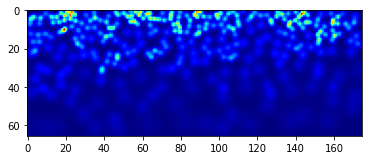

In [22]:
estimate_density_map(img_root,gt_dmap_root,model_checkpoint_path,3) 

Predicted Count :  310


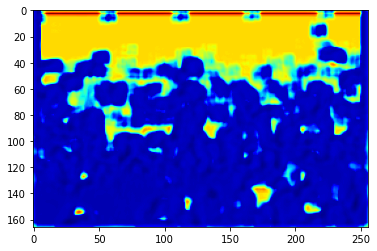

Original Count :  429


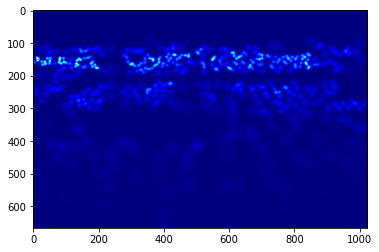

Original Image


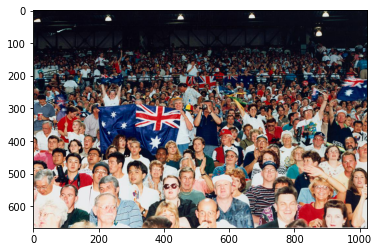

In [24]:
image = transform(Image.open('/content/drive/My Drive/ShanghaiTech/part_A/test_data/images/IMG_103.jpg').convert('RGB')).cuda()

result = mcnn(image.unsqueeze(0))
print("Predicted Count : ",int(result.detach().cpu().sum().numpy()))
first = np.asarray(result.detach().cpu().reshape(result.detach().cpu().shape[2],result.detach().cpu().shape[3]))
plt.imshow(first,cmap = CM.jet)
plt.show()
first = h5py.File('/content/drive/My Drive/ShanghaiTech/part_A/test_data/ground-truth/IMG_103.h5', 'r')
second = np.asarray(first['density'])
plt.imshow(second,cmap = CM.jet)
print("Original Count : ",int(np.sum(second)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/ShanghaiTech/part_A/test_data/images/IMG_103.jpg'))
plt.show()